# Artificial Neural Network

# Importing all the libraries

In [1]:
import time
import glob
import math
import keras
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.constraints import maxnorm
from sklearn.model_selection import train_test_split


# Dataset import

In [2]:
# Training set
train_val_data = pd.read_csv("trainingData.csv")

# Test set
test_data = pd.read_csv("validationData.csv")

# visualize data points

## Training data visualize

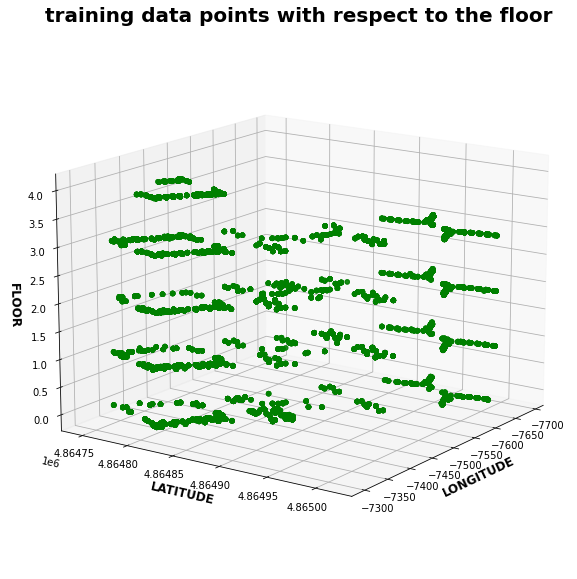

In [3]:
# Creating dataset
x_tr = train_val_data ['LONGITUDE']
y_tr = train_val_data ['LATITUDE']
z_tr = train_val_data ['FLOOR']

# Creating figure
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection ="3d")
ax.view_init(15, 35)

# Creating plot
ax.scatter3D(x_tr, y_tr, z_tr, color = "green")
plt.title("training data points with respect to the floor", fontweight ='bold',fontsize =20)
ax.set_xlabel('LONGITUDE', fontweight ='bold',fontsize =12)
ax.set_ylabel('LATITUDE', fontweight ='bold', fontsize =12)
ax.set_zlabel('FLOOR', fontweight ='bold',fontsize =12)

# show plot
plt.show()


No handles with labels found to put in legend.


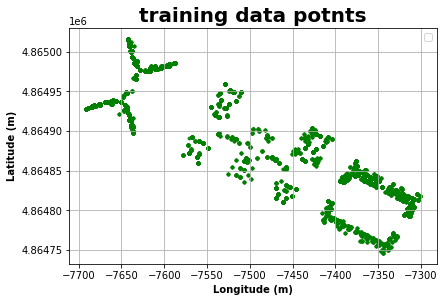

<Figure size 7200x7200 with 0 Axes>

In [4]:
# color plot
plt.figure()
plt.scatter(x_tr, y_tr, alpha=0.5, s=7, marker='o', color='green')
plt.legend()
plt.grid()
plt.xlabel('Longitude (m)', fontweight ='bold')
plt.ylabel('Latitude (m)', fontweight ='bold')
plt.title("training data potnts", fontweight ='bold',fontsize =20)
plt.tight_layout(pad=0)
fig = plt.figure(figsize=(100,100))
plt.show()

## Testing data visualize

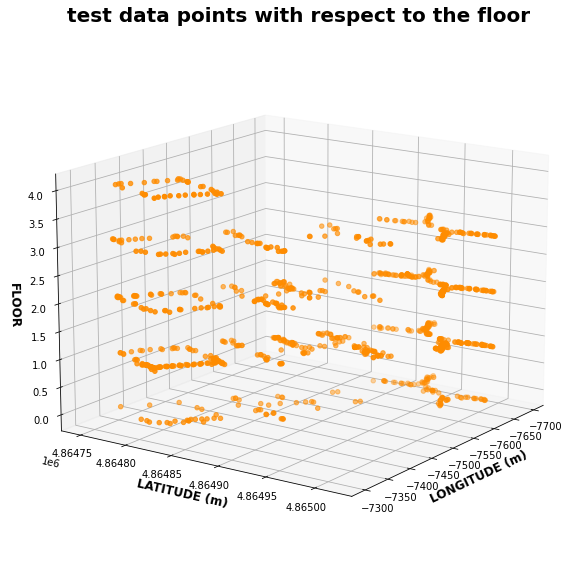

In [5]:
# Creating dataset
x_ts = test_data ['LONGITUDE']
y_ts = test_data ['LATITUDE']
z_ts = test_data ['FLOOR']

# Creating figure
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection ="3d")
ax.view_init(15, 35)

# Creating plot
ax.scatter3D(x_ts, y_ts, z_ts, color = "darkorange")
plt.title("test data points with respect to the floor", fontweight ='bold',fontsize =20)
ax.set_xlabel('LONGITUDE (m)', fontweight ='bold',fontsize =12)
ax.set_ylabel('LATITUDE (m)', fontweight ='bold', fontsize =12)
ax.set_zlabel('FLOOR', fontweight ='bold', fontsize =12)

# show plot
plt.show()

No handles with labels found to put in legend.


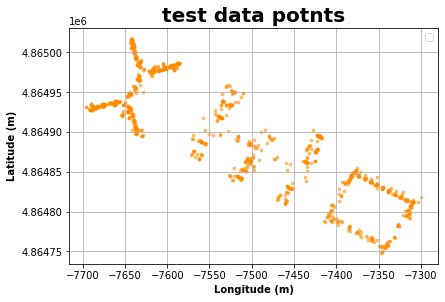

<Figure size 7200x7200 with 0 Axes>

In [6]:
# color plot
plt.figure()
plt.scatter(x_ts, y_ts, alpha=0.5, s=7, marker='o', color='darkorange')
plt.legend()
plt.grid()
plt.xlabel('Longitude (m)', fontweight ='bold')
plt.ylabel('Latitude (m)', fontweight ='bold')
plt.title("test data potnts", fontweight ='bold',fontsize =20)
plt.tight_layout(pad=0)
fig = plt.figure(figsize=(100,100))
plt.show()

# Preprocess Data

## Training data preprocess

In [7]:
# Positive representation for all Wi-fi Access Points
train_val_data.iloc[:, 0:520].min().min() 
train_val_data_P = train_val_data.copy()
train_val_data_P.iloc[:, 0:520] = np.where(train_val_data_P.iloc[:, 0:520] <= 0, train_val_data_P.iloc[:, 0:520] + 105, train_val_data_P.iloc[:, 0:520] - 100) 


In [8]:
# Normalize the Wifi Access Points
train_val_data_PN = train_val_data_P.copy()
train_val_data_PN.iloc[:, 0:520].max().max()
train_val_data_PN.iloc[:, 0:520] = train_val_data_P.iloc[:, 0:520]/105


In [9]:
# Create a single label for the model to predict
# Combine training data and test data 
# Then assign that into unique position

resultant = pd.concat([train_val_data_PN, test_data]) 
resultant = resultant.assign(unique_pos = (resultant['LONGITUDE'].astype(str) + '_' + resultant['LATITUDE'].astype(str) + '_' + resultant['FLOOR'].astype(str) + '_' + resultant['BUILDINGID'].astype(str)).astype('category').cat.codes)
len(resultant["unique_pos"].unique()) 


1997

In [10]:
# Split the data set again
train_val_data_PUN = resultant.iloc[0:19937, :] # training data consist of 19937 values
test_data_U = resultant.iloc[19937:21048, :] # test data consist of 1111 values


In [11]:
# Change variable types
train_val_data_PUN["unique_pos"] = train_val_data_PUN["unique_pos"].astype("category")
train_val_data_PUN.dtypes


<ipython-input-11-a4fabcd4aa82>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_val_data_PUN["unique_pos"] = train_val_data_PUN["unique_pos"].astype("category")


WAP001               float64
WAP002               float64
WAP003               float64
WAP004               float64
WAP005               float64
                      ...   
RELATIVEPOSITION       int64
USERID                 int64
PHONEID                int64
TIMESTAMP              int64
unique_pos          category
Length: 530, dtype: object

In [12]:
# Since unique_pos is a multi-class label
dummy = keras.utils.to_categorical(train_val_data_PUN['unique_pos'], num_classes = 1997)
dummy = pd.DataFrame(dummy, dtype = 'int')
train_val_data_PUND = pd.concat([train_val_data_PUN, dummy] ,axis = 1)


In [13]:
# Split the data set 
X_train_val = train_val_data_PUND.iloc[:, 0:520]
y_train_val = train_val_data_PUND.iloc[:, 520:2525]


## Test data preprocess

In [14]:
# Positive representation for all Wi-fi Access Points
test_data_PU = test_data_U.copy()
test_data_PU.iloc[:, 0:520] = np.where(test_data_PU.iloc[:, 0:520] <= 0, test_data_PU.iloc[:, 0:520] + 105, test_data_PU.iloc[:, 0:520] - 100) 

In [15]:
# Normalize the Wifi Access Points
test_data_PUN = test_data_PU.copy()
test_data_PUN.iloc[:, 0:520].max().max()
test_data_PUN.iloc[:, 0:520] = test_data_PU.iloc[:, 0:520]/105


In [16]:
# Change variable types
test_data_PUN["unique_pos"] = test_data_PUN["unique_pos"].astype("category")
test_data_PUN.dtypes


WAP001               float64
WAP002               float64
WAP003               float64
WAP004               float64
WAP005               float64
                      ...   
RELATIVEPOSITION       int64
USERID                 int64
PHONEID                int64
TIMESTAMP              int64
unique_pos          category
Length: 530, dtype: object

In [17]:
# Since unique_pos is a multi-class label
dummy = keras.utils.to_categorical(test_data_PUN['unique_pos'], num_classes = 1997)
dummy = pd.DataFrame(dummy, dtype = 'int')
test_data_PUND = pd.concat([test_data_PUN, dummy] ,axis = 1)


In [18]:
# Split the data set 
X_test = test_data_PUND.iloc[:, 0:520]
y_test = test_data_PUND.iloc[:, 520:2525]


In [19]:
# Split processed train_val data into training data and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 0)

In [20]:
# Create a reference table 
reference_table = pd.concat([y_train.iloc[:, [0,1,2,3,9]], y_val.iloc[:, [0,1,2,3,9]], y_test.iloc[:, [0,1,2,3,9]]])
reference_table = reference_table.drop_duplicates()


# Train Model

In [21]:
# Hyperparameters 
parameters = {'epochs': 100, 'batch_size': 800, 'hidden_layers': 1, 'neurons': 1600, 'lambd': None, 'dropout': None} 

In [22]:

def create_model(num_features, num_classes, hidden_layers = 1, neurons = 1250, lambd = 0, dropout = 0): 
   
    # create model
    model = Sequential() 
    
    # input layer and hidden layer
    model.add(Dense(input_dim = num_features, units = neurons, kernel_initializer = 'glorot_uniform', activation = 'relu'))
    
    # output layer
    model.add(Dense(units = num_classes, kernel_initializer = 'glorot_uniform', activation='softmax'))
    
    # compile model 
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [metrics.categorical_accuracy])
    
    model.summary()
    return model
    

In [23]:
# Fix seed for reproducibility and to minimize differences in model performance
np.random.seed(0)

In [24]:
# Training process
model = create_model(num_features = X_train.shape[1], num_classes = 1995, 
                    hidden_layers = parameters['hidden_layers'],
                    neurons = parameters['neurons'], 
                    lambd = parameters['lambd'],
                    dropout = parameters['dropout'])

start_time = time.time()

model.fit(X_train, y_train.iloc[:, 10:2005], 
                 batch_size = parameters['batch_size'], epochs = parameters['epochs'], 
                 verbose = True, # this says how do we want to see the training progress for each epoch. in here this shows a progress_bar
                 shuffle = True) # shuffle training data before each epoch

end_time = time.time()

# Elapsed time in minutes
run_time = (end_time - start_time)/60 


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1600)              833600    
_________________________________________________________________
dense_1 (Dense)              (None, 1995)              3193995   
Total params: 4,027,595
Trainable params: 4,027,595
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
20/20 [==============================] - 10s 207ms/step - loss: 7.3920 - categorical_accuracy: 0.0609
Epoch 2/100
20/20 [==============================] - 4s 194ms/step - loss: 5.7458 - categorical_accuracy: 0.0956
Epoch 3/100
20/20 [==============================] - 4s 193ms/step - loss: 4.1859 - categorical_accuracy: 0.1550
Epoch 4/100
20/20 [==============================] - 4s 196ms/step - loss: 3.2657 - categorical_accuracy: 0.2515
Epoch 5/100
20/20 [==============================] - 4s

In [25]:
# Training data performance
train_performance = model.evaluate(X_train, y_train.iloc[:, 10:2005])
model.metrics_names

499/499 [==============================] - 7s 13ms/step - loss: 0.2226 - categorical_accuracy: 0.9438


['loss', 'categorical_accuracy']

In [26]:
# Validation data performance
val_performance = model.evaluate(X_val, y_val.iloc[:, 10:2005], batch_size = 5)
model.metrics_names

798/798 [==============================] - 4s 4ms/step - loss: 0.6931 - categorical_accuracy: 0.7951


['loss', 'categorical_accuracy']

In [27]:
# Save performance results into a csv file

performance = pd.DataFrame({'model': 'ann', 
                            'fit_time (min)': [run_time], 
                            'epochs': [parameters['epochs']], 
                            'batch_size': [parameters['batch_size']],
                            'hidden_layers': [parameters['hidden_layers']],
                            'hidden_layer_neurons': [parameters['neurons']],
                            'L2_regularization': [parameters['lambd']],
                            'dropout_rate': [parameters['dropout']],
                            'train_accuracy': [train_performance[1]],
                            'val_accuracy': [val_performance[1]],
                            'train_accuracy - val_accuracy': [train_performance[1] - val_performance[1]]})


with open('performance.csv', 'a') as f:
    performance.to_csv(f,header = True, index = False)
    
performance

model  fit_time (min)  epochs  batch_size  hidden_layers  \
0   ann        7.727913     100         800              1   

   hidden_layer_neurons L2_regularization dropout_rate  train_accuracy  \
0                  1600              None         None        0.943821   

   val_accuracy  train_accuracy - val_accuracy  
0      0.795135                       0.148686

In [28]:
# Test data performance
y_pred = np.argmax(model.predict(X_test), axis = 1)

# Test values
y_test_pos = y_test.iloc[:, 0:2].values 
y_test_floor = y_test.iloc[:, 2].values
y_test_building = y_test.iloc[:, 3].values

dict_loc = {}
m_total = reference_table.shape[0]
for i in range(m_total):
    key = int(reference_table.iloc[i]['unique_pos'])
    value = reference_table.iloc[i, 0:4].values
    dict_loc[key] = value

# Predicted values
y_pred_pos = np.asarray([dict_loc[i] for i in y_pred])[:, 0:2] 
y_pred_floor = np.asarray([dict_loc[i] for i in y_pred])[:, 2]
y_pred_building = np.asarray([dict_loc[i] for i in y_pred])[:, 3]

## distance error = prediction errors based on euclidean distances

In [29]:
def distance_error(y_test_pos, y_pred_pos):
    
    m_test = y_test_pos.shape[0]
    dist_error = np.sqrt(np.sum((y_test_pos - y_pred_pos)**2, axis = 1))
    return dist_error



In [30]:
# Position errors for each test data point
dist_error = distance_error(y_test_pos, y_pred_pos) 
sorted_dist_error = sorted(dist_error)

m_test = y_test.shape[0]

# mean positional error
mean_error = np.mean(dist_error) 

# building prediction accuracy
building_accuracy  = np.mean(y_test_building == y_pred_building)

# floor prediction accuracy
floor_accuracy = np.mean(y_test_floor == y_pred_floor)

In [31]:
# Save test results into a CSV file
test_results = pd.DataFrame({'building_accuracy': building_accuracy, 'floor_accuracy': floor_accuracy, 'mean_error (m)': mean_error},index=[0]) 

with open('test_results.csv', 'a') as f:
    test_results.to_csv(f,header = True, index = False)

test_results

building_accuracy  floor_accuracy  mean_error (m)
0                1.0         0.90279        8.674276

# Results visualization

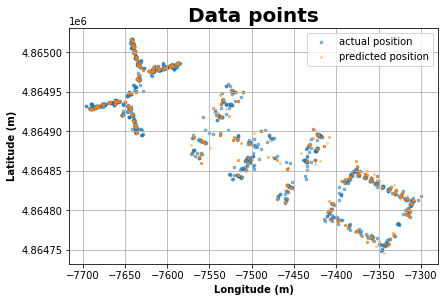

<Figure size 7200x7200 with 0 Axes>

In [32]:
    # Put the result into a color plot
    plt.figure()
    plt.scatter(y_test_pos[:, 0], y_test_pos[:, 1], alpha=0.5, s=7, marker='o', label='actual position')
    plt.scatter(y_pred_pos[:, 0], y_pred_pos[:, 1], alpha=0.3, s=4, marker='o', label='predicted position')
    plt.legend()
    plt.grid()
    plt.xlabel('Longitude (m)', fontweight ='bold')
    plt.ylabel('Latitude (m)', fontweight ='bold')
    plt.title("Data points", fontweight ='bold',fontsize =20)
    plt.tight_layout(pad=0)
    fig = plt.figure(figsize=(100,100))
    plt.savefig('data_points.png')
    plt.show()

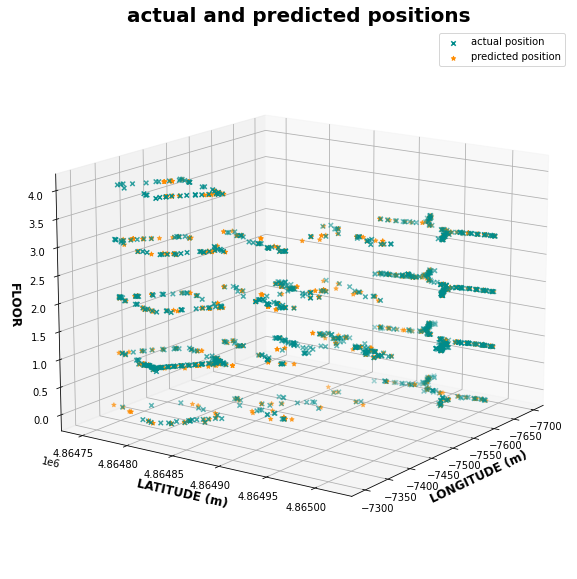

In [33]:
# Creating figure
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection ="3d")
ax.view_init(15, 35)

# Creating plot
l1 = ax.scatter3D(y_pred_pos[:, 0],  y_pred_pos[:, 1], y_pred_floor, color = "darkorange" , marker = '*')
ax.set_xlabel('LONGITUDE', fontweight ='bold', fontsize =12)
ax.set_ylabel('LATITUDE', fontweight ='bold', fontsize =12)
ax.set_zlabel('FLOOR', fontweight ='bold', fontsize =12)

l2 = ax.scatter3D(y_test_pos[:, 0],  y_test_pos[:, 1], y_test_floor, color = "darkcyan" , marker = 'x')
plt.title("actual and predicted positions", fontweight ='bold',fontsize =20)
ax.set_xlabel('LONGITUDE (m)', fontweight ='bold', fontsize =12)
ax.set_ylabel('LATITUDE (m)', fontweight ='bold', fontsize =12)
ax.set_zlabel('FLOOR', fontweight ='bold', fontsize =12)

ax.legend([l2,l1], ['actual position', 'predicted position'], numpoints = 1)
# show plot
plt.show()


In [34]:
# Save outputs into a CSV file

output = pd.DataFrame({'actual_longitude (m)': y_test_pos[:, 0] , 
                       'actual_latitude (m)': y_test_pos[:, 1], 
                       'predicted_longitude (m)': y_pred_pos[:, 0], 
                       'predicted_latitude (m)': y_pred_pos[:, 1] ,
                       'error_longitude (m)': y_test_pos[:, 0] -y_pred_pos[:, 0],
                       'error_latitude (m)':  y_test_pos[:, 1] -y_pred_pos[:, 1] ,
                       'distance_error(m)': np.round(distance_error(y_test_pos, y_pred_pos),2)})


with open('output.csv', 'w') as f:
    output.to_csv(f,header = True, index = False)
    
output

actual_longitude (m)  actual_latitude (m)  predicted_longitude (m)  \
0             -7515.916799         4.864890e+06              -7524.35130   
1             -7383.867221         4.864840e+06              -7385.52640   
2             -7374.302080         4.864847e+06              -7370.01070   
3             -7365.824883         4.864843e+06              -7359.14850   
4             -7641.499303         4.864922e+06              -7641.32980   
...                    ...                  ...                      ...   
1106          -7317.344231         4.864796e+06              -7313.73112   
1107          -7313.731120         4.864792e+06              -7313.73112   
1108          -7637.535798         4.864903e+06              -7636.96020   
1109          -7636.654005         4.864905e+06              -7639.13620   
1110          -7637.944120         4.864904e+06              -7636.96020   

      predicted_latitude (m)  error_longitude (m)  error_latitude (m)  \
0               4.864934e+06             8.434501       -4.482728e+01   
1               4.864839e+06             1.659179        7.813072e-01   
2               4.864848e+06            -4.291380       -1.219778e+00   
3               4.864842e+06            -6.676383        1.102154e+00   
4               4.864921e+06            -0.169503        1.769678e+00   
...                      ...                  ...                 ...   
1106            4.864792e+06            -3.613111        3.466647e+00   
1107            4.864792e+06             0.000000        5.587935e-09   
1108            4.864906e+06            -0.575598       -2.430275e+00   
1109            4.864913e+06             2.482195       -8.315437e+00   
1110            4.864906e+06            -0.983920       -2.123800e+00   

      distance_error(m)  
0                 45.61  
1                  1.83  
2                  4.46  
3                  6.77  
4                  1.78  
...                 ...  
1106               5.01  
1107               0.00  
1108               2.50  
1109               8.68  
1110               2.34  

[1111 rows x 7 columns]